# Assignment 2: Multi-layer Feed Forward Neural Networks

Solutions to assignment #2 by K. Sai Somanath, 18MCMT28

## Question 1
## Extracting the images

In [2]:
# Necessary imports
import os
import struct
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [3]:
# Some utility functions to read and extract data in desired format
def read(dataset = "training", path = "."):
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        print("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        _, __, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows * cols)

    get_img = lambda index: (lbl[index], img[index])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

def show(image):
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image.reshape(28, 28), cmap=mpl.cm.gray)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

In [4]:
# Reading the images
TRAIN = read('training', 'MNIST'); TEST = read('testing', 'MNIST')

In [5]:
img_train = []; lbl_train = []
img_test = []; lbl_test = []

for temp in TRAIN:
    img_train.append(temp[1])
    lbl_train.append(temp[0])

for temp in TEST:
    img_test.append(temp[1])
    lbl_test.append(temp[0])

img_train = np.array(img_train); lbl_train = np.array(lbl_train)
img_test = np.array(img_test); lbl_test = np.array(lbl_test)

### The dataset
A look at a random image to make sure everything went well

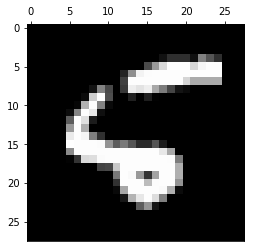

5


In [6]:
show(img_test[8])
print(lbl_test[8])

### One hot encoding the labels of the images

In [7]:
lbl_train = np.eye(10)[lbl_train]
lbl_test = np.eye(10)[lbl_test]

In [8]:
lbl_test.shape

(10000, 10)

Now the labels in the trainig smaplemhave been one hot encoded. Instaed of having a single digit representing the class name, we instead use a vector of size 10 to represent the class of the image

In [9]:
lbl_test[8]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

## The MLFFNN

In [10]:
class Relu:
    @staticmethod
    def activation(z):
        z[z < 0] = 0
        return z
    
    @staticmethod
    def derivative(z):
        z[z < 0] = 0
        z[z > 0] = 1
        return z
        
class Sigmoid:
    @staticmethod
    def activation(z):
        return 1 / (1 + np.exp(-z))
    
    @staticmethod
    def derivative(z):
        return Sigmoid.activation(z) * (1 - Sigmoid.activation(z))
    
class MSE:
    def __init__(self, activation_fn=None):
        self.activation_fn = activation_fn
            
    def activation(self, z):
        return self.activation_fn.activation(z)

    @staticmethod
    def loss(y_true, y_pred):
        return np.mean((y_pred - y_true)**2)

    @staticmethod
    def derivative(y_true, y_pred):
        return y_pred - y_true

    def delta(self, y_true, y_pred):
        return self.derivative(y_true, y_pred) * self.activation_fn.derivative(y_pred)
    

class NeuralNetwork(object):
    def __init__(self, dimensions, activation_fns):
        self.n_layers = len(dimensions)
        self.loss = None
        self.learning_rate = None
        self.weights = {}
        self.bais = {}
        self.activations = {}
        for i in range(self.n_layers - 1):
            self.weights[i + 1] = np.random.randn(dimensions[i], dimensions[i + 1]) / np.sqrt(dimensions[i])
            self.bais[i + 1] = np.zeros(dimensions[i + 1])
            self.activations[i + 2] = activation_fns[i]
            
    def feed_forward(self, x):
        z = {}
        activated = {1: x}
        for i in range(1, self.n_layers):
            z[i + 1] = np.dot(activated[i], self.weights[i]) + self.bais[i]
            activated[i + 1] = self.activations[i + 1].activation(z[i + 1])
        return z, activated
    
    def back_propagation(self, z, a, y_true):
        delta = self.loss.delta(y_true, a[self.n_layers])
        partial_derivative = np.dot(a[self.n_layers - 1].T, delta)

        update_params = {
            self.n_layers - 1: (partial_derivative, delta)
        }

        for i in reversed(range(2, self.n_layers)):
            delta = np.dot(delta, self.weights[i].T) * self.activations[i].derivative(z[i])
            partial_derivative = np.dot(a[i - 1].T, delta)
            update_params[i - 1] = (partial_derivative, delta)

        for key, values in update_params.items():
            self.update_fn(key, values[0], values[1])
        
    def update_fn(self, key, partial_derivative, delta):
        self.weights[key] -= self.learning_rate * partial_derivative
        self.bais[key] -= self.learning_rate * np.mean(delta, 0)

    def learn(self, x, y_true, loss, epochs, batch_size, learning_rate):
        self.loss = loss(self.activations[self.n_layers])
        self.learning_rate = learning_rate
        for i in range(epochs):
            seed = np.arange(x.shape[0])
            np.random.shuffle(seed)
            x_ = x[seed]
            y_ = y_true[seed]
            for j in range(x.shape[0] // batch_size):
                k = j * batch_size
                l = (j + 1) * batch_size
                z, a = self.feed_forward(x_[k:l])
                self.back_propagation(z, a, y_[k:l])

            if (i + 1) % 100 == 0:
                _, a = self.feed_forward(x)
                print("Epoch", i + 1, "Loss:", self.loss.loss(y_true, a[self.n_layers]))
    
    def predict(self, x):
        _, a = self.feed_forward(x)
        return a[self.n_layers]


The above class allows us to create a network pf arbitary size and supports ReLU and Sigmoid as activations functions. 

Cross-validation is used to determine the better model for this problem, the value of k is 5, i.e. we create 5 splits of the data set. We then will use the results obtained model contructed in each fold to find the better one.

In [53]:
X = np.copy(img_train)
Y = np.copy(lbl_train)

# Creating the 5 fold cross-validation 
kf = KFold(n_splits=5)
"""
We create a new model in each fold and train on 4 splits while we hold the 5th split for testing. We repeat this 
process for all the combinations. We store the accuracy for each split and discard the model. The model with 
better accuracy will the better suited for our problem.
"""

# Define the models
"""This neural network has 3 layers, 784 input neurons, 100 in the hidden layer, and 10 in the output layer.
We use a learning rate of 0.01 and a modest 200 epochs to get a rough idea aboyt the model"""
nn1 = NeuralNetwork((784, 100, 10), (Sigmoid, Sigmoid))

"""This neural network has 4 layers, 784 input neurons, 64, 64 in the hidden layers, and 10 in the output layer.
We use a learning rate of 0.1 and a modest 200 epochs to get a rough idea aboyt the model"""
nn2 = NeuralNetwork((784, 64, 64, 10), (Sigmoid, Sigmoid, Sigmoid))

## The error array is used to hold the errors made in each fold.
e1 = []; e2 = []

In [54]:
for train, test in kf.split(X):
    i = 1
    x = X[train]; y = Y[train]
    x_ = X[test]; y_ = Y[test]
    print("Split: ", i)
    i += 1
    nn1.learn(x, y, MSE, 200, 128, 0.01)
    y_pred = np.argmax(nn1.predict(x_), axis=1)
    y_true = np.argmax(y_, axis=1)
    e1.append(accuracy_score(y_true, y_pred))

Split:  1


/home/sai/.virtualenvs/Tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


Epoch 100 Loss: 0.02207418208672041
Epoch 200 Loss: 0.0185524114703845
Split:  1
Epoch 100 Loss: 0.018316540070854512
Epoch 200 Loss: 0.015244878327379679
Split:  1
Epoch 100 Loss: 0.014882411752147834
Epoch 200 Loss: 0.014106201201793175
Split:  1
Epoch 100 Loss: 0.013916263955573096
Epoch 200 Loss: 0.013251018019402873
Split:  1
Epoch 100 Loss: 0.01517111243308256
Epoch 200 Loss: 0.013064052700995976


In [55]:
e1

[0.88425,
 0.8983333333333333,
 0.9075833333333333,
 0.9096666666666666,
 0.9229166666666667]

In [56]:
i = 1
for train, test in kf.split(X):
    x = X[train]; y = Y[train]
    x_ = X[test]; y_ = Y[test]
    print("Split: ", i)
    i += 1
    nn2.learn(x, y, MSE, 200, 128, 0.01)
    y_pred = np.argmax(nn2.predict(x_), axis=1)
    y_true = np.argmax(y_, axis=1)
    e2.append(accuracy_score(y_true, y_pred))

Split:  1


/home/sai/.virtualenvs/Tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


Epoch 100 Loss: 0.01642738241306958
Epoch 200 Loss: 0.015496486477681627
Split:  2
Epoch 100 Loss: 0.014911084301548173
Epoch 200 Loss: 0.01526763052835603
Split:  3
Epoch 100 Loss: 0.012297334503243895
Epoch 200 Loss: 0.012020532603717075
Split:  4
Epoch 100 Loss: 0.011415938785978432
Epoch 200 Loss: 0.012294607753273854
Split:  5
Epoch 100 Loss: 0.010926281419909993
Epoch 200 Loss: 0.010916970340238894


In [57]:
e2

[0.89675, 0.8975, 0.9150833333333334, 0.9105833333333333, 0.93]

In [58]:
e1 = np.array(e1); e2 = np.array(e2)
print(e1.mean(), e2.mean())

0.9045499999999999 0.9099833333333333


We can see that model two just barely performs better. We therefore choose, the secnod model to solve the problem.

## The Digit classifier
We have determined that the neural network #2 is the better one to perform classification. We will now train it to on the entire dataset.

We use each pixel as a feature to train the network. This results in a network that takes $28\times28$ number of pixels as input. We have two hidden layers each with 64 nuerons, activated by a Sigmoid function. Lastly, the output layer has 10 neuron which determine the class label of a given input image. 

In [11]:
nn_simple = NeuralNetwork((784, 64, 64, 10), (Sigmoid, Sigmoid, Sigmoid))

# Train the network
nn_simple.learn(img_train, lbl_train, MSE, 1000, 128, 0.01)

/home/sai/.virtualenvs/Tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


Epoch 100 Loss: 0.015662487240742894
Epoch 200 Loss: 0.016782339588961283
Epoch 300 Loss: 0.01466834661138394
Epoch 400 Loss: 0.012416464708358409
Epoch 500 Loss: 0.011188861745651162
Epoch 600 Loss: 0.011494422683120084
Epoch 700 Loss: 0.011974595774067396
Epoch 800 Loss: 0.011700113850517332
Epoch 900 Loss: 0.010191649931897539
Epoch 1000 Loss: 0.010433829690871354


### Some metrics to guage the performance of the model

In [14]:
# Mak epredictions on the test set
y_pred = np.argmax(nn_simple.predict(img_test), axis=1)
# Get the true labels
y_true = np.argmax(lbl_test, axis=1)
print("Metrics of Performance")
print("Accuracy: ", accuracy_score(y_true, y_pred) * 100, "%")
print("-----------------------------------------------------")
print("\n\nConfusion Matrix\n")
print(confusion_matrix(y_pred, y_true))
print("-------------------------------------------------------")
print("\n\nOther metrics\n")
print(classification_report(y_pred, y_true))

Metrics of Performance
Accuracy:  92.43 %
-----------------------------------------------------


Confusion Matrix

[[ 953    1   14    5    1   17   10    2    7    6]
 [   0 1114    4    4    1    1    2    6    3    7]
 [   1    4  951   17    9    4    6   23    4    1]
 [   2    4   12  884    1   28    1    5   17   13]
 [   5    0    8    1  901    1    6    5    7   29]
 [   8    1    1   51    1  802   10    0   35   25]
 [   5    4    9    2   10   14  918    0   12    1]
 [   2    1   12   11   10    7    0  961    4   16]
 [   1    6   19   24    3   17    5    3  872   24]
 [   3    0    2   11   45    1    0   23   13  887]]
-------------------------------------------------------


Other metrics

             precision    recall  f1-score   support

          0       0.97      0.94      0.95      1016
          1       0.98      0.98      0.98      1142
          2       0.92      0.93      0.93      1020
          3       0.88      0.91      0.89       967
          4   

/home/sai/.virtualenvs/Tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


We have scored an accuracy of about 92%. From the precision column we note that apart from class 3 and class 9, every other class has high precision. This is also evident from the consfusion matrix. 

When we look at the loss that the model reported at training time, we notice that it performed it's best by the end of 500 epochs, but it shows some improvement later. We can get a better model, with more epochs.

## Question 2
Use KNN classifier to learn hand written digits

In [15]:
# Import the KNN from sklearn
from sklearn.neighbors import KNeighborsClassifier

# Perform 1 Nearest Neighbour
K = 1

### Change the input data format for 1-NN

In [17]:
y_train = np.argmax(lbl_train, axis=1)
y_test = np.argmax(lbl_test, axis=1)

### Training a 1NN model

In [18]:
clf_1nn = KNeighborsClassifier(K)
clf_1nn.fit(img_train, y_train)
acc = clf_1nn.score(img_test, y_test)
print("Accuracy = ", (acc * 100))

Accuracy =  96.91


In [19]:
knn_pred = clf_1nn.predict(img_test)
print("Metrics of Performance")
print("Accuracy: ", accuracy_score(y_true, knn_pred) * 100, "%")
print("-----------------------------------------------------")
print("\n\nConfusion Matrix\n")
print(confusion_matrix(knn_pred, y_true))
print("-------------------------------------------------------")
print("\n\nOther metrics\n")
print(classification_report(knn_pred, y_true))

Metrics of Performance
Accuracy:  96.91 %
-----------------------------------------------------


Confusion Matrix

[[ 973    0    7    0    0    1    4    0    6    2]
 [   1 1129    6    1    7    1    2   14    1    5]
 [   1    3  992    2    0    0    0    6    3    1]
 [   0    0    5  970    0   12    0    2   14    6]
 [   0    1    1    1  944    2    3    4    5   10]
 [   1    1    0   19    0  860    5    0   13    5]
 [   3    1    2    0    3    5  944    0    3    1]
 [   1    0   16    7    5    1    0  992    4   11]
 [   0    0    3    7    1    6    0    0  920    1]
 [   0    0    0    3   22    4    0   10    5  967]]
-------------------------------------------------------


Other metrics

             precision    recall  f1-score   support

          0       0.99      0.98      0.99       993
          1       0.99      0.97      0.98      1167
          2       0.96      0.98      0.97      1008
          3       0.96      0.96      0.96      1009
          4   

### Analysis and Oberservations